## 数据清理与特征工程

### 1. 处理movie_item

载入包文件

In [1]:
import pandas as pd
import numpy as np
import json
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
# %load_ext scalene

载入数据

In [2]:
# 载入电影数据
data_item = pd.read_json('../douban_movie/data/movie_item.json', lines=True)
print('电影数目：' ,data_item.shape[0])

data_item['movie_id'] = data_item['movie_id'].apply(lambda x: int(x[0][3:]))  # [电影-1300267] -> int(1300267)
data_item['comment_num'] = data_item['comment_num'].apply(lambda x: int(x[2:-1]))  # 全部 62309 条 -> int(62309)
data_item['question_num'] = data_item['question_num'].apply(lambda x: int(x[2:-1]))  # 全部23个 -> int(23)
data_item['rating_num'] = data_item['rating_num'].apply(lambda x: float(x[0]))   # [9.2] -> float(9.2)
data_item['rating_per_stars1'] = data_item['rating_per_stars1'].apply(lambda x: float(x[:-1]))   # 0.1% -> float(0.1)
data_item['rating_per_stars2'] = data_item['rating_per_stars2'].apply(lambda x: float(x[:-1]))  
data_item['rating_per_stars3'] = data_item['rating_per_stars3'].apply(lambda x: float(x[:-1]))  
data_item['rating_per_stars4'] = data_item['rating_per_stars4'].apply(lambda x: float(x[:-1]))  
data_item['rating_per_stars5'] = data_item['rating_per_stars5'].apply(lambda x: float(x[:-1]))
data_item['release_date'] = data_item['release_date'].apply(lambda x: int(x[0][1:-1]))  # [(1939)] -> int(1939)
data_item['vote_num'] = data_item['vote_num'].apply(lambda x: int(x[0]))   # [272357] -> int(272357)
data_item['movie_title'] = data_item['movie_title'].apply(lambda x: (x[0]))
# [238分钟] -> 238
data_item.loc[15,'runtime'] = ['80分钟']
pattern = '\d+'
import re
data_item['runtime'] = data_item['runtime'].apply(lambda x: (x[0]))
data_item['runtime'] = data_item['runtime'].str.findall(pattern,flags=re.IGNORECASE).apply(lambda x: int(x[0]))

def Intro(introduces):
    Intro_ = ''
    for intro in introduces:
        intro = intro.strip()
        Intro_ += intro
    return Intro_
data_item['intro'] = data_item.intro.apply(Intro)

电影数目： 246


In [3]:
# 总评分最高的前10部电影
data_item.sort_values('rating_num', ascending=False)[['movie_title','rating_num']].head(10)

,movie_title,rating_num
243,肖申克的救赎 The Shawshank Redemption,9.6
236,控方证人 Witness for the Prosecution,9.6
102,美丽人生 La vita è bella,9.5
98,霸王别姬,9.5
107,十二怒汉 12 Angry Men,9.4
103,阿甘正传 Forrest Gump,9.4
101,这个杀手不太冷 Léon,9.4
100,辛德勒的名单 Schindler's List,9.4
108,机器人总动员 WALL·E,9.3
120,海豚湾 The Cove,9.3


In [4]:
def column_expand(data, column, list_values):
    for cl in list_values:
        tt = data_item[column].apply(lambda x: str(x)).str.contains('\W'+cl+'\W')
        uu = data_item[column].apply(lambda x: str(x)).str.contains('^'+cl+'$')
        ee = data_item[column].apply(lambda x: str(x)).str.contains(cl+'\s')
        ff = data_item[column].apply(lambda x: str(x)).str.contains('\s'+cl)
#         print('cl', cl)
#         print('tt', tt)
#         print('uu', uu)
#         print('ee', ee)
        cl_ = tt | uu| ee | ff
        cl_ *= 1
#         print('c1_', cl_)
        data['%s_%s' %(column ,cl)] = cl_
#         print('data', data)
        
class_movie = ['剧情','爱情','喜剧','科幻','动作','悬疑','犯罪','恐怖','青春'
               ,'励志','战争','文艺','黑色幽默','传记','情色','暴力','音乐','家庭']
country_movie = ['大陆','美国','香港','台湾','日本','韩国','英国','法国','德国','意大利','西班牙','印度','泰国','俄罗斯'
 ,'伊朗','加拿大','澳大利亚','爱尔兰','瑞典','巴西','丹麦']

def get_values_list(data, column, sep=None):
    Language_values=[]
    def countLANG(Languages):
        for language in Languages:
            language = language.strip()
            if language in Language_values: 
                continue
            else:
                Language_values.append(language)
    if sep:
        pd.DataFrame(data[column].str.split(sep))[column].apply(countLANG);
    else:
        data[column].apply(countLANG);
    return Language_values

def Paiming(data, column, list_values):
    column_expand(data, column, list_values)
    df = pd.DataFrame( 
        {'数目':[data['%s_%s' %(column, p)].sum() for p in list_values]}
        , index=list_values).sort_values('数目', ascending=False)
    return df

In [5]:
# 最受欢迎的电影导演排名
temp = Paiming(data_item, 'directedBy', get_values_list(data_item, 'directedBy'))
print('共有%s位导演入选TOP250电影榜:' %len(temp))
temp.head(10)

共有196位导演入选TOP250电影榜:


/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_69712/2886496474.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_


,数目
克里斯托弗·诺兰,7
宫崎骏,7
史蒂文·斯皮尔伯格,6
王家卫,5
李安,4
大卫·芬奇,3
刘镇伟,3
理查德·林克莱特,3
朱塞佩·托纳多雷,3
詹姆斯·卡梅隆,3


In [6]:
# 最受欢迎的电影类别排名
movie_type_list = Paiming(data_item, 'genre', class_movie)
print(movie_type_list)

       数目
剧情    191
爱情     62
喜剧     49
犯罪     45
动作     32
悬疑     29
家庭     27
科幻     25
战争     17
传记     12
音乐      7
恐怖      2
情色      1
青春      0
文艺      0
黑色幽默    0
暴力      0
励志      0


/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_69712/2886496474.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_


In [7]:
# 最受欢迎的演员排名
temp = Paiming(data_item, 'starring', get_values_list(data_item, 'starring'))
print('共有%s位演员入选TOP250电影榜:' %len(temp))
temp.head(11)

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_69712/2886496474.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_69712/2886496474.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  tt = data_item[column].apply(lambda x: str(x)).str.contains('\W'+cl+'\W')
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_69712/2886496474.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  uu = data_item[column].apply(lambda x: str(x)).str.contains('^'+cl+'$')
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_69712/2886496474.py:5: UserWarning: This pattern has

共有2317位演员入选TOP250电影榜:


,数目
张国荣,8
汤姆·汉克斯,7
布拉德·皮特,7
张曼玉,7
梁朝伟,7
伊桑·霍克,6
琼·艾伦,6
马特·达蒙,6
雨果·维文,6
莱昂纳多·迪卡普里奥,6


In [8]:
# 最受欢迎的出品国家排名
temp = Paiming(data_item, 'country', country_movie)
print('共有%s个出品国家入选TOP250电影榜:' %len(temp))
temp.head(15)
temp

共有21个出品国家入选TOP250电影榜:


/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_69712/2886496474.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_


,数目
美国,141
英国,34
日本,29
法国,27
香港,26
德国,19
意大利,10
韩国,8
大陆,7
加拿大,7


In [9]:
def geod_world(df, title, legend = False):
    """
    temp0 = temp.reset_index()
    df = pd.DataFrame({'NAME': temp0['index'].map(country_dict).tolist() 
                   ,'NUM': (np.log1p(temp0['数目'])*100).tolist()})
    """
    import geopandas as gp
    from matplotlib import pyplot as plt
    %matplotlib inline
    import matplotlib
    import seaborn as sns
    matplotlib.rc('figure', figsize = (14, 7))
    matplotlib.rc('font', size = 14)
    matplotlib.rc('axes', grid = False)
    matplotlib.rc('axes', facecolor = 'white')

    world_geod = gp.GeoDataFrame.from_file('./world_countries_shp/World_countries_shp.shp')
    data_geod = gp.GeoDataFrame(df)   # 转换格式
    da_merge = world_geod.merge(data_geod, on = 'NAME', how = 'left') # 合并
    sum(np.isnan(da_merge['NUM'])) # 
    da_merge['NUM'][np.isnan(da_merge['NUM'])] = 14.0#填充缺失数据
    da_merge.plot('NUM', k = 20, cmap = plt.cm.Blues,alpha= 1,legend = legend)
    plt.title(title, fontsize=15)#设置图形标题
    plt.gca().xaxis.set_major_locator(plt.NullLocator())#去掉x轴刻度
    plt.gca().yaxis.set_major_locator(plt.NullLocator())#去年y轴刻度

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_69712/576203789.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da_merge['NUM'][np.isnan(da_merge['NUM'])] = 14.0#填充缺失数据


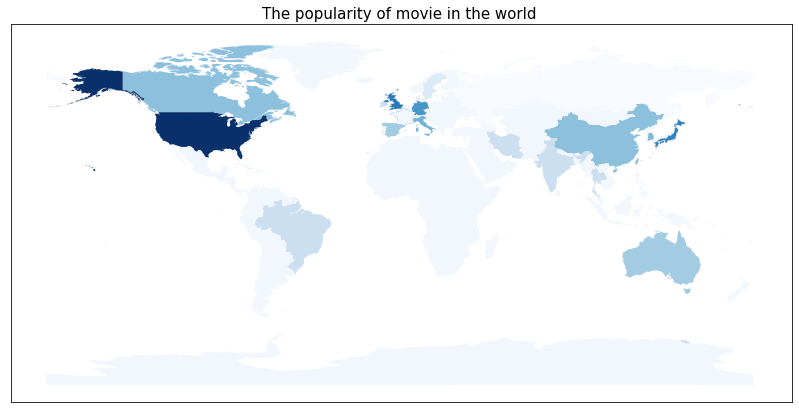

In [10]:
country_dict = {'大陆':'China','美国':'United States','香港':'Hong Kong','台湾':'Taiwan, Province of China'
                 ,'日本':'Japan','韩国':'Korea, Republic of','英国':'United Kingdom','法国':'France','德国':'Germany'
                 ,'意大利':'Italy','西班牙':'Spain','印度':'India','泰国':'Thailand','俄罗斯':'Russian Federation'
                 ,'伊朗':'Iran','加拿大':'Canada','澳大利亚':'Australia','爱尔兰':'Ireland','瑞典':'Sweden'
                 ,'巴西':'Brazil','丹麦':'Denmark'}

temp0 = temp.reset_index()
df = pd.DataFrame({'NAME': temp0['index'].map(country_dict).tolist() 
                   ,'NUM': (np.log1p(temp0['数目'])*100).tolist()})
geod_world(df, 'The popularity of movie in the world ')

In [11]:
# 最受欢迎的语言排名
temp = Paiming(data_item, 'language', get_values_list(data_item, 'language', sep='/'))
print('共有%s种语言入选TOP250电影榜:' %len(temp))
temp.head(15)

共有60种语言入选TOP250电影榜:


/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_69712/2886496474.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_


,数目
英语,170
法语,41
日语,37
汉语普通话,33
德语,25
粤语,24
意大利语,19
西班牙语,15
俄语,12
拉丁语,8


In [12]:
# 电影时长的排名
data_item.sort_values('runtime', ascending=False)[['movie_title','runtime']].head(10)

,movie_title,runtime
0,乱世佳人 Gone with the Wind,238
221,牯岭街少年杀人事件 牯嶺街少年殺人事件,237
235,美国往事 Once Upon a Time in America,229
199,教父2 The Godfather: Part Ⅱ,202
110,指环王3：王者无敌 The Lord of the Rings: The Return of...,201
100,辛德勒的名单 Schindler's List,195
104,泰坦尼克号 Titanic,194
230,绿里奇迹 The Green Mile,189
11,与狼共舞 Dances with Wolves,181
210,指环王2：双塔奇兵 The Lord of the Rings: The Two Towers,179


In [13]:
# 电影投票数的排名
data_item.sort_values('vote_num', ascending=False)[['movie_title','vote_num']].head(10)

,movie_title,vote_num
243,肖申克的救赎 The Shawshank Redemption,877684
101,这个杀手不太冷 Léon,838853
105,盗梦空间 Inception,766735
103,阿甘正传 Forrest Gump,714946
28,三傻大闹宝莱坞 3 Idiots,676928
106,千与千寻 千と千尋の神隠し,666166
104,泰坦尼克号 Titanic,657294
98,霸王别姬,631204
171,让子弹飞,612443
26,海上钢琴师 La leggenda del pianista sull'oceano,601595


In [14]:
# 电影评价数的排名
data_item.sort_values('comment_num', ascending=False)[['movie_title','comment_num']].head(10)

,movie_title,comment_num
243,肖申克的救赎 The Shawshank Redemption,206334
105,盗梦空间 Inception,201260
113,少年派的奇幻漂流 Life of Pi,197790
28,三傻大闹宝莱坞 3 Idiots,192686
101,这个杀手不太冷 Léon,192324
83,疯狂动物城 Zootopia,182765
109,怦然心动 Flipped,178532
111,星际穿越 Interstellar,176341
98,霸王别姬,167573
171,让子弹飞,155386


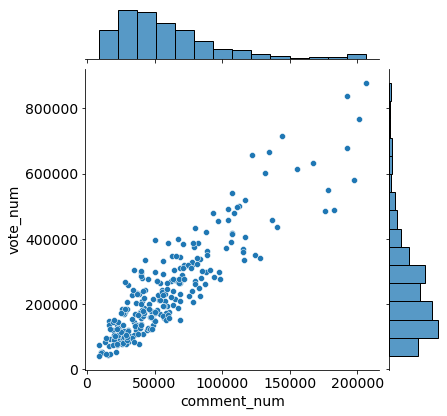

In [15]:
import seaborn as sns
sns.jointplot(x="comment_num", y="vote_num", data=data_item)

In [16]:
# 电影问题数的排名
data_item.sort_values('question_num', ascending=False)[['movie_title','question_num']].head(10)

,movie_title,question_num
111,星际穿越 Interstellar,1215
196,消失的爱人 Gone Girl,282
83,疯狂动物城 Zootopia,264
19,彗星来的那一夜 Coherence,200
161,心迷宫,184
163,超能陆战队 Big Hero 6,142
172,布达佩斯大饭店 The Grand Budapest Hotel,135
224,爆裂鼓手 Whiplash,133
223,恐怖游轮 Triangle,119
231,再次出发之纽约遇见你 Begin Again,116


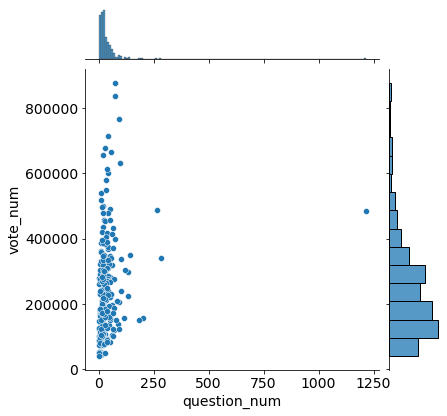

In [17]:
sns.jointplot(x="question_num", y="vote_num", data=data_item)

In [18]:
# 根据电影发布时间的规律
def plot2y(x_data, x_label, type1, y1_data, y1_color, y1_label, type2, y2_data, y2_color, y2_label, title):
    _, ax1 = plt.subplots()
    
    if type1 == 'hist':
        ax1.hist(x_data, histtype='stepfilled', bins=200, color = y1_color)
        ax1.set_ylabel(y1_label, color = y1_color) 
        ax1.set_xlabel(x_label)
        ax1.set_yscale('symlog')
        ax1.set_title(title)

    elif type1 == 'plot':
        ax1.plot(x_data, y1_data, color = y1_color)
        ax1.set_ylabel(y1_label, color = y1_color) 
        ax1.set_xlabel(x_label)
        ax1.set_yscale('linear')
        ax1.set_title(title)
        
    elif type1 == 'scatter':
        ax1.scatter(x_data, y1_data, color = y1_color, s = 10, alpha = 0.75)
        ax1.set_ylabel(y1_label, color = y1_color) 
        ax1.set_xlabel(x_label)
        ax1.set_yscale('symlog')
        ax1.set_title(title)
        
    if type2 == 'bar':
        ax2 = ax1.twinx()
        ax2.bar(x_data, y2_data, color = y2_color, alpha = 0.75)
        ax2.set_ylabel(y2_label, color = y2_color)
        ax2.set_yscale('linear')
        ax2.spines['right'].set_visible(True)
        
    elif type2 == 'scatter':
        ax2 = ax1.twinx()
        ax2.scatter(x_data, y2_data, color = y2_color, s = 10, alpha = 0.75)
        ax2.set_ylabel(y2_label, color = y2_color)
        ax2.set_yscale('linear')
        ax2.spines['right'].set_visible(True)

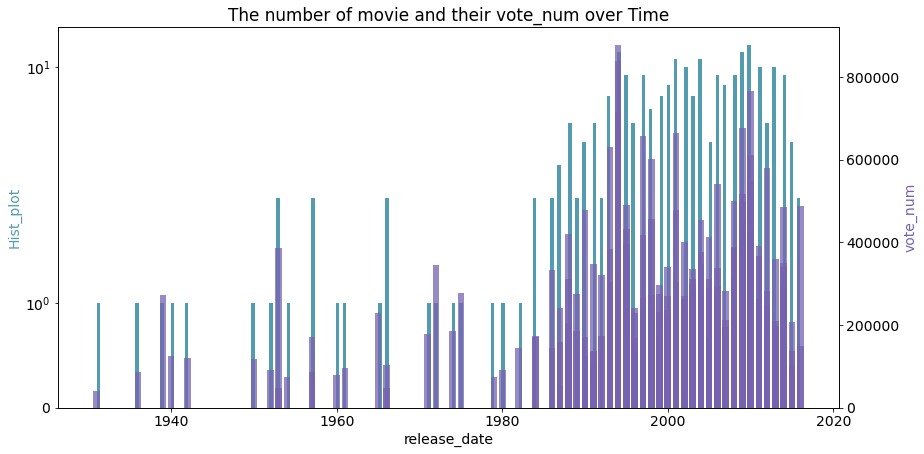

In [19]:
from matplotlib import pyplot as plt
plot2y(x_data = data_item.release_date
           , x_label = 'release_date'
           , type1 = 'hist'
           , y1_data = data_item.vote_num #(无效果)
           , y1_color = '#539caf'
           , y1_label = 'Hist_plot'
           , type2 = 'bar'
           , y2_data = data_item.vote_num
           , y2_color = '#7663b0'
           , y2_label = 'vote_num'
           , title = 'The number of movie and their vote_num over Time')

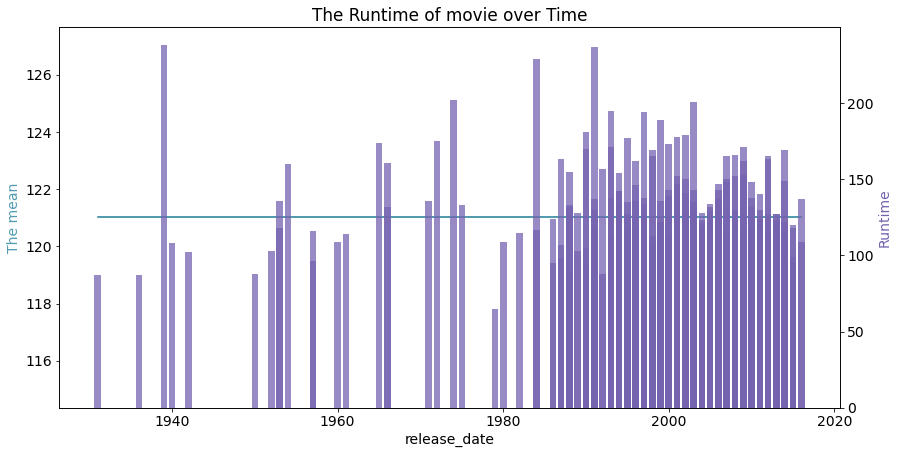

In [20]:
plot2y(x_data = data_item.release_date
           , x_label = 'release_date'
           , type1 = 'plot'
           , y1_data = data_item.runtime.apply(lambda x : data_item.runtime.mean())
           , y1_color = '#539caf'
           , y1_label = 'The mean'
           , type2 = 'bar'
           , y2_data = data_item.runtime
           , y2_color = '#7663b0'
           , y2_label = 'Runtime'
           , title = 'The Runtime of movie over Time')

In [21]:
# 1～5星级投票的百分比

/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributi

Text(0.5, 1.0, 'Rating percent for stars 1-5')

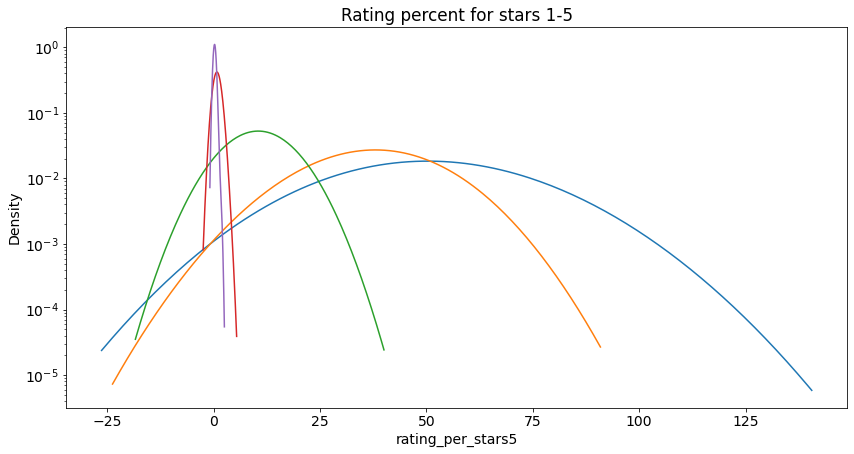

In [22]:
sns.kdeplot(data_item.rating_per_stars5, bw=2)
sns.kdeplot(data_item.rating_per_stars4, bw=2)
sns.kdeplot(data_item.rating_per_stars3, bw=2)
sns.kdeplot(data_item.rating_per_stars2, bw=2)
sns.kdeplot(data_item.rating_per_stars1, bw=2)
plt.yscale('log')
plt.title('Rating percent for stars 1-5')

In [23]:
# 电影简介的情感分析

In [24]:
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy as np
# import codecs
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize']=(10.0,5.0)
from wordcloud import WordCloud # 词云包

In [25]:
# 导入、分词、去停用词 
def lcut(Intro_movie):
    segment=[]
    segs = jieba.lcut(Intro_movie) # jiaba.lcut()   
    for seg in segs:
        if len(seg)>1 and seg!='\r\n':
            segment.append(seg)
    return segment

def dropstopword(segment):
    # 去停用词
    words_df = pd.DataFrame({'segment':segment})
    stopwords = pd.read_csv("../stopwords.txt" 
                      ,index_col=False
                      ,quoting=3
                      ,sep="\t"
                      ,names=['stopword']
                      ,encoding='utf-8') # quoting=3 全不引用    
    #stopwords.head()
    return words_df[~words_df.segment.isin(stopwords.stopword)].segment.values.tolist()

In [26]:
# 基于TextRank算法的关键词抽取(仅动词和动名词)
import jieba.analyse as analyse

data_item['keywords'] = data_item.intro.apply(lcut)\
                .apply(dropstopword)\
                .apply(lambda x : " ".join(x))\
                .apply(lambda x:" ".join(analyse.textrank(x, topK=8, withWeight=False, allowPOS=('n','ns','vn', 'v'))))
data_item.sort_values('rating_num', ascending=False)[['movie_title','keywords']].head(10)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/jieba.cache
Loading model cost 0.468 seconds.
Prefix dict has been built successfully.


,movie_title,keywords
243,肖申克的救赎 The Shawshank Redemption,监狱 希望 本片 惩罚 牢狱 管理层 接近 杀害
236,控方证人 Witness for the Prosecution,律师 嫌疑犯 遗嘱 警方 护士 刑案 爵士 本片
102,美丽人生 La vita è bella,儿子 圭多 法西斯 早安 公主 政权 游戏 妻子
98,霸王别姬,人生 程蝶衣 关系 风云 升级 变迁 本质 情仇
107,十二怒汉 12 Angry Men,陪审员 有罪 陪审团 被告 父亲 过程 证人 涉嫌
103,阿甘正传 Forrest Gump,妈妈 外交 美国 性格 坚强 至爱 离别 思念
101,这个杀手不太冷 Léon,女孩 邻居家 杀害 警方 缉毒 混杂着 暂避 救回
100,辛德勒的名单 Schindler's List,统治 工厂 德国 屠杀 军官 贿赂 拯救 出众
108,机器人总动员 WALL·E,地球 漫长 机器人 垃圾 公司 生活 飞船 蟑螂
120,海豚湾 The Cove,海豚 拯救 太地 渔民 渔村 县太地 景色 理查德


### 2. 处理movie_comment

In [27]:
import pandas as pd
import numpy as np
import json
# 短评数据
movie_comment_file = ['../douban_movie/data/movie_comment%s.json' %j for j in [ i for i in range(20,220,20)] +[225,250]]
com = []
for f in movie_comment_file:
    lines = open(f, 'rb').readlines()
    com.extend([json.loads(elem.decode("utf-8")) for elem in lines])
data_com = pd.DataFrame(com)
print(data_com)
data_com['movie_id'] = data_com['movie_id'].apply(lambda x: int(x[0][5:]))
data_com['content'] = data_com.content.apply(lambda x: x[0].strip())
data_com['people'] = data_com.people.apply(lambda x: x.strip())
data_com['people'] = data_com.people_url.apply(lambda x: x[30:-1])
data_com['useful_num'] = data_com.useful_num.apply(lambda x: int(x))
def regular_nonstar(x):
    if x == 'comment-time':
        return 'allstar00 rating'
    else:
        return x
data_com['star'] = data_com.star.apply(regular_nonstar).apply(lambda x: int(x[7]))
data_com['time'] = pd.to_datetime(data_com.time.apply(lambda x: x[0]))
print('获取的总短评数：' ,data_com.shape[0])

              movie_id                                                URL  \
0       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
1       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
2       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
3       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
4       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
...                ...                                                ...   
249555  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   
249556  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   
249557  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   
249558  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   
249559  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   

                    star                                            content

In [28]:
data_com = data_com[~data_com.comment_id.duplicated()]
print('去重后的总短评数：' ,data_com.shape[0])

people_url = data_com.people_url.unique().tolist()
np.savetxt('../douban_movie/bin/people_url.out', people_url, fmt='%s')
urllist = np.loadtxt('../douban_movie/bin/people_url.out', dtype='|S').tolist()
len(urllist)

去重后的总短评数： 249512


38599

In [29]:
data_com = data_com.drop(['URL','people_url'], axis=1)
print(data_com.head(1))
data_com['label'] = (data_com.star >=3) *1

   movie_id  star     content  comment_id    people  useful_num  \
0   1292052     5  不需要女主角的好电影     2050003  kingfish       11314   

                 time  
0 2006-03-22 12:38:09  


In [30]:
data_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249512 entries, 0 to 249559
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   movie_id    249512 non-null  int64         
 1   star        249512 non-null  int64         
 2   content     249512 non-null  object        
 3   comment_id  249512 non-null  int64         
 4   people      249512 non-null  object        
 5   useful_num  249512 non-null  int64         
 6   time        249512 non-null  datetime64[ns]
 7   label       249512 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 17.1+ MB


In [31]:
data_com.head(2)

,movie_id,star,content,comment_id,people,useful_num,time,label
0,1292052,5,不需要女主角的好电影,2050003,kingfish,11314,2006-03-22 12:38:09,1
1,1292052,5,恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》,32514679,ruxiaoguo,7277,2008-02-27 21:43:23,1


In [32]:
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy
import codecs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
from wordcloud import WordCloud # 词云包

In [33]:
def cut_word(content):
    # 导入、分词
    segment=[]
    for line in content: 
        try:
            segs = jieba.lcut(line) # jiaba.lcut() 
#             print(segs)
            for seg in segs:
                if len(seg)>1 and seg!='\r\n':
                    segment.append(seg)
        except:
            print(line)
            continue
#     print('cut_word', segment[:1000])
    return segment
cut_word(['阔别三十多年的同学，生活在不同的地方，有才华横溢事业有成的，有投资有方商海弄潮的，也有固守田园风光难舍故乡'])

['阔别',
 '三十多年',
 '同学',
 '生活',
 '不同',
 '地方',
 '才华横溢',
 '事业有成',
 '投资',
 '有方',
 '商海',
 '弄潮',
 '固守',
 '田园风光',
 '难舍',
 '故乡']

In [34]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
def tf_idf_words(segment):
    content = ' '.join(segment)
    cv = TfidfVectorizer()
    cv.fit_transform([content])
#     print(content[:1000])
#     print(cv.get_feature_names())
    return cv.get_feature_names()
# tf_idf_words(['三十多年', '不同', '事业有成', '同学', '商海', '固守', '地方', '弄潮', '才华横溢', '投资', '故乡', '有方'])

In [35]:
def remove_stopword(segment):
    # 去停用词
    words_df = pd.DataFrame({'segment':segment})
    stopwords = pd.read_csv("../stopwords.txt" 
                          ,index_col=False
                          ,quoting=3
                          ,sep="\t"
                          ,names=['stopword']
                          ,encoding='utf-8') # quoting=3 全不引用    
    words_df=words_df[~words_df.segment.isin(stopwords.stopword)]
    return words_df

In [36]:
# 统计词频
def get_word_count(words_df):
    words_stat = words_df.groupby('segment').agg(计数=pd.NamedAgg(column='segment', aggfunc='size')).reset_index().sort_values(by='计数', ascending=False)
    return words_stat

In [37]:
# 词云展示
import imageio
matplotlib.rcParams['figure.figsize']=(10.0,10.0)
from wordcloud import WordCloud,ImageColorGenerator
def createWordCloud(imgPath, words_stat={}):
    bimg=imageio.imread('cover.jpg')
    wordcloud=WordCloud(background_color="white",mask=bimg,font_path='../simhei.ttf',max_font_size=200)
    word_frequence={x[0]:x[1] for x in words_stat.head(1000).values}
    wordcloud=wordcloud.fit_words(word_frequence)
    bimgColors=ImageColorGenerator(bimg)
    plt.axis("off")
    plt.imshow(wordcloud.recolor(color_func=bimgColors))

In [38]:
def createWordCloudByGenre(content, imgPath='cover.jpg'):
    segment = cut_word(content)
#     print('segment', segment)
#     segment = tf_idf_words(segment)
#     print('segment', segment)
    words_df = remove_stopword(segment)
    words_stat = get_word_count(words_df)
    createWordCloud(imgPath,words_stat=words_stat)

In [39]:
# 合并电影短评
movie_comment_data = pd.merge(data_item, data_com, on="movie_id")

In [40]:
# 对最受欢迎的前五条电影类别进行分析
movie_top_five = movie_type_list.head(5).index
print(movie_top_five)
# movie_type={x: x.index for x in movie_type_list}
# print(movie_type)
# # 获取方式某个题材的影评
def get_comment(genre):
    flag = movie_comment_data['genre'].apply(lambda x: str(x)).str.contains(genre)
    content = movie_comment_data[flag].content
    return content

Index(['剧情', '爱情', '喜剧', '犯罪', '动作'], dtype='object')


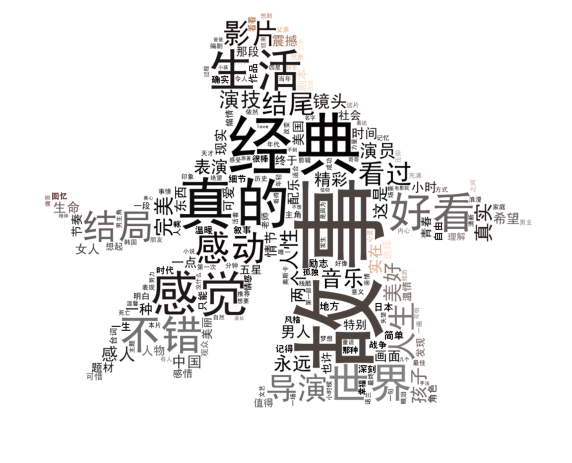

In [41]:
# 词云展示最受欢迎的五个类型评论
comment = get_comment('剧情').values.tolist()
createWordCloudByGenre(comment)

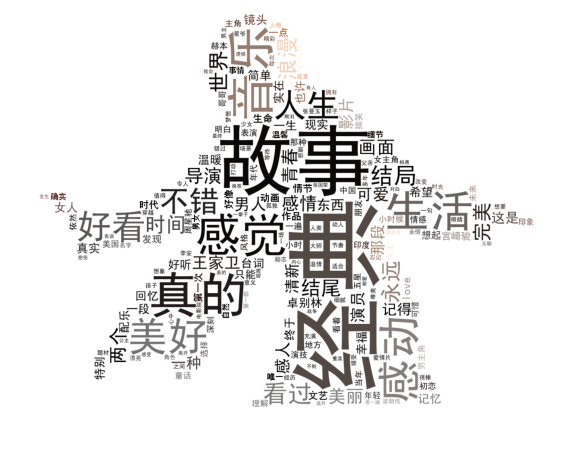

In [42]:
comment = get_comment('爱情').values.tolist()
createWordCloudByGenre(comment)

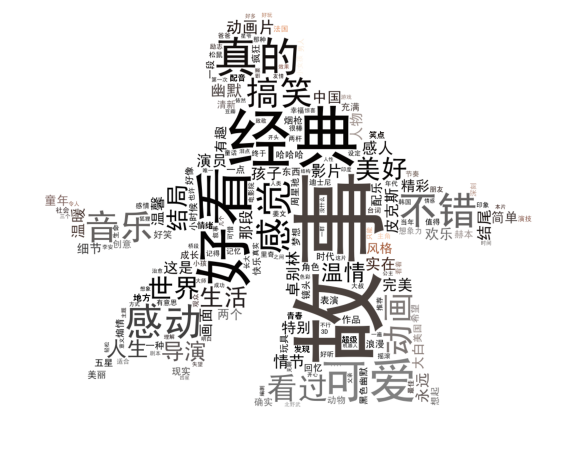

In [43]:
comment = get_comment('喜剧').values.tolist()
createWordCloudByGenre(comment)

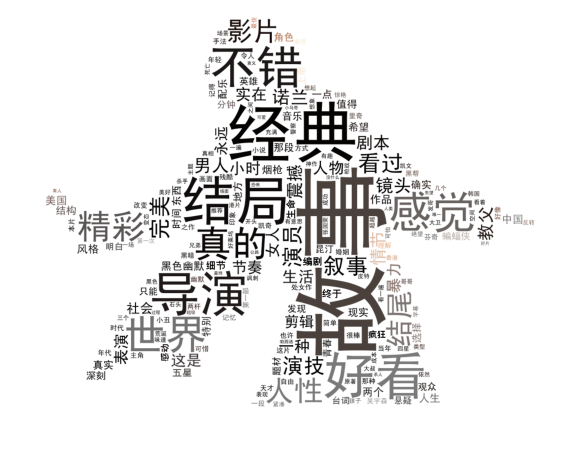

In [44]:
comment = get_comment('犯罪').values.tolist()
createWordCloudByGenre(comment)

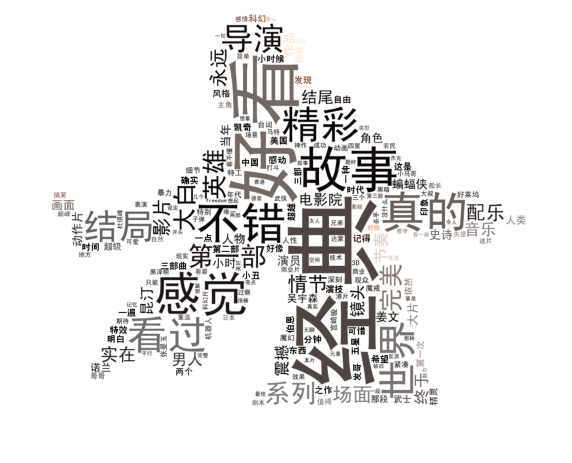

In [45]:
comment = get_comment('动作').values.tolist()
createWordCloudByGenre(comment)

In [46]:
# tf-dif

1309046    1060
1291992    1060
5322596    1060
2353023    1060
6307447    1060
           ... 
2129039     840
1418200     839
1292528     839
1294240     838
2209573     819
Name: movie_id, Length: 245, dtype: int64


Text(0.5, 0, 'Number of short_comment of each movie')

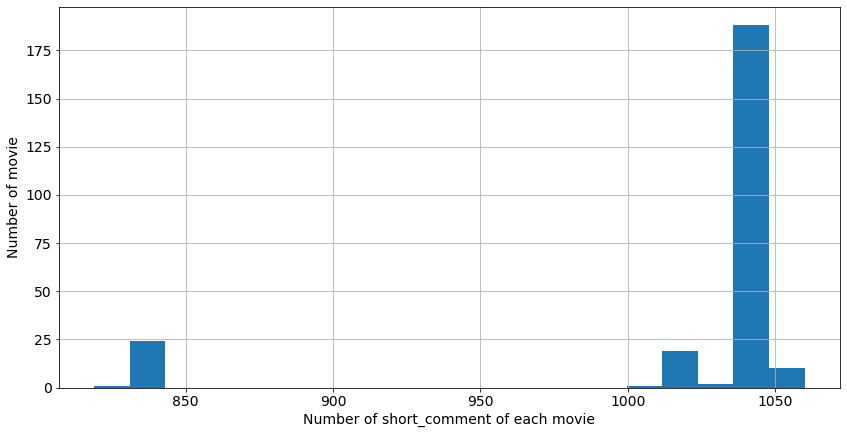

In [72]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

data_com.movie_id.value_counts().hist(bins=20)
print(data_com.movie_id.value_counts())
plt.ylabel('Number of movie')
plt.xlabel('Number of short_comment of each movie')

In [48]:
# 1. 就《肖申克的救赎》这个电影而言

In [49]:
data_com_X = data_com[data_com.movie_id == 1307914]
print(data_com_X.head(10))
print('爬取《肖申克的救赎》的短评数：', data_com_X.shape[0])

     movie_id  star                                            content  \
380   1307914     5                                  牛就牛在，他让所有演员都达到了巅峰   
381   1307914     4    我还是不能理解为什么美国人可以这么无耻直接拿本子过去拍出烂片还得了奥斯卡但是不给这部片子正名?   
382   1307914     5                                     当年我深刻的爱上了梁朝伟同学   
383   1307914     4                           看了美版的，才知道港版有多好看~55555555   
384   1307914     5  “出来混，迟早要还的。” 别说，这种港片老爸老妈们已经欣赏不了了，就连弟弟一起看都没坚持看完...   
385   1307914     0                                            百年不遇的经典   
386   1307914     5                                     说不好的人都不懂电影只懂装逼   
387   1307914     4  “《无间道》拍得相当好，但是再好也已经没有当年港片热气腾腾的生命力了。不知是拍的人变了，还是...   
388   1307914     5  最后那一下爆头，刘德华和梁朝伟的眼神里都是震惊，他死在电梯里，电梯门来回的开关，我们也从震惊...   
389   1307914     5                                             港片的里程碑   

     comment_id       people  useful_num                time  label  
380    11262269  naocanqiang        4268 2007-03-03 02:07:09      1  
381   485478001     tofucius        3682 2012

In [50]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

Text(0, 0.5, 'Number of short_comment')

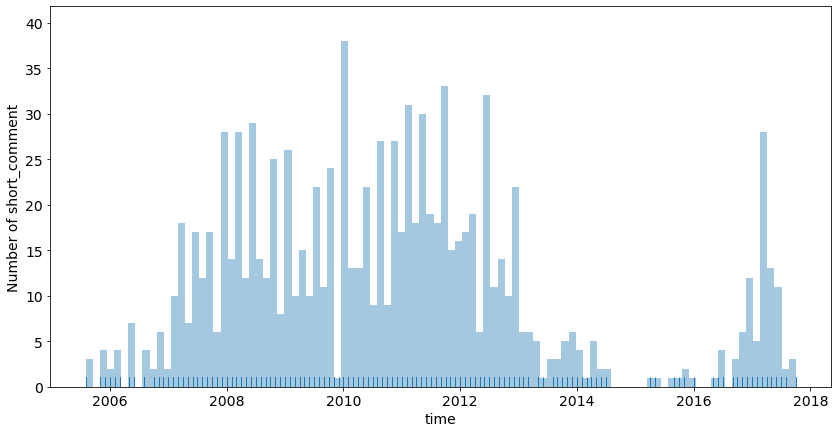

In [51]:
sns.distplot(data_com_X.time.apply(lambda x: int(x.year)+float(x.month/12.0)), bins=100, kde=False, rug=True)
plt.xlabel('time')
plt.ylabel('Number of short_comment')

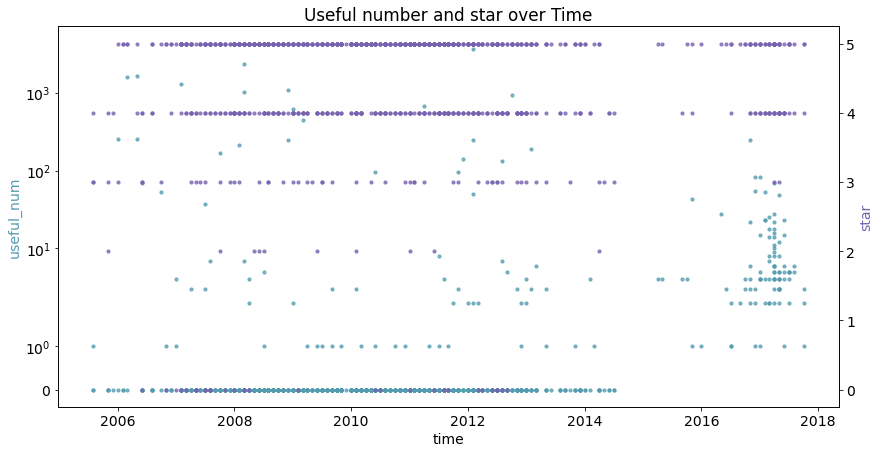

In [52]:
plot2y(x_data = data_com_X.time.apply(lambda x: int(x.year)+float(x.month/12.0))
           , x_label = 'time'
           , type1 = 'scatter'
           , y1_data = data_com_X['useful_num']
           , y1_color = '#539caf'
           , y1_label = 'useful_num'
           , type2 = 'scatter'
           , y2_data = data_com_X['star']
           , y2_color = '#7663b0'
           , y2_label = 'star'
           , title = 'Useful number and star over Time')

In [53]:
# 短评词云

In [54]:
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy
import codecs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
from wordcloud import WordCloud # 词云包

In [55]:
content_X = data_com_X.content.dropna().values.tolist()
print(content_X)
# 导入、分词
segment=[]
for line in content_X: 
    try:
        segs = jieba.lcut(line) # jiaba.lcut()   
        for seg in segs:
            if len(seg)>1 and seg!='\r\n':
                segment.append(seg)
    except:
        print(line)
        continue

['牛就牛在，他让所有演员都达到了巅峰', '我还是不能理解为什么美国人可以这么无耻直接拿本子过去拍出烂片还得了奥斯卡但是不给这部片子正名?', '当年我深刻的爱上了梁朝伟同学', '看了美版的，才知道港版有多好看~55555555', '“出来混，迟早要还的。” 别说，这种港片老爸老妈们已经欣赏不了了，就连弟弟一起看都没坚持看完，哎，我说，片子都这么牛逼了，对你们来说却成不了经典，叹息。', '百年不遇的经典', '说不好的人都不懂电影只懂装逼', '“《无间道》拍得相当好，但是再好也已经没有当年港片热气腾腾的生命力了。不知是拍的人变了，还是看的人倦了。《无间道》的前传后续也声势闹猛，它似乎可以打破港片沉沦的僵局。但是，它更像一具艳尸，妆扮得精美绝色，但终究是死物。”网上的这段评论深得我心。', '最后那一下爆头，刘德华和梁朝伟的眼神里都是震惊，他死在电梯里，电梯门来回的开关，我们也从震惊中恢复，觉得残酷，谁说的，好人有好报，那些为民除害的，都死了。会有人惦记着他们吗？把他们视为英雄吗？又有什么用呢，这个社会还不都是恶人当道。', '港片的里程碑', '梁朝伟已经无与伦比了，那忧郁的眼神，欧~~', '看刘德华演戏好累', '经典港片，无间道，如人生~~', '剧情写得好！', '难怪高中时大家那么喜欢。片尾才发现，陈永仁的生日和我一样。', '我最喜欢是它的色调', '让全世界人重新对香港电影刮目相看的电影，它从哲学的角度直接深入探索人性，去感受身不由己之下的那种窒息，感受贪婪与自私，和所谓的善与恶。编剧确实是相当的出色，梁朝伟的陈松仁直接神化，所有的角色都可圈可点，没有一出多余的地方，以至多年后看美版的时候仍然不忘旧爱。这是港片的里程碑', '梁朝伟演得真好，配乐好熟悉。如果这是一部外国电影，评分肯定更高。没办法，豆瓣就是崇洋媚外。', '卧！槽！居！然！这！么！好！看！（好后悔现在才看这部电影……所有人的演技都太棒了，甚至萧亚轩……）', '其实这部片子我并没有觉出任何好来，所有人都装着深沉.因此无论怎样都可以继续神展开，总结一下就是：一部大家从头到尾都在努力装着一直装到最后还要装下去的片子.交换角色身份的片子，梁朝伟过得很杯具.其实所有人装着装着连自己的身份都快要忽悠掉了，白的想黑，黑的想白.对了这个有原著么？', '重看才觉出经典的味道。', '一气呵成

In [56]:
# 去停用词
words_df = pd.DataFrame({'segment':segment})
stopwords = pd.read_csv("../stopwords.txt" 
                      ,index_col=False
                      ,quoting=3
                      ,sep="\t"
                      ,names=['stopword']
                      ,encoding='utf-8') # quoting=3 全不引用    
#stopwords.head()
print(words_df.segment)
words_df=words_df[~words_df.segment.isin(stopwords.stopword)]

0        所有
1        演员
2        达到
3        巅峰
4        还是
       ... 
6682     感觉
6683     深深
6684     触动
6685     准备
6686    看一遍
Name: segment, Length: 6687, dtype: object


In [57]:
# 统计词频
# words_stat = words_df.groupby(by=['segment'])['segment'].agg({"计数":np.size})
# words_stat=words_stat.reset_index().sort_values(by=["计数"],ascending=False
words_stat = words_df.groupby('segment').agg(计数=pd.NamedAgg(column='segment', aggfunc='size')).reset_index().sort_values(by='计数', ascending=False)
print(words_stat.segment.tolist())
#words_stat.head()

['经典', '港片', '香港电影', '香港', '梁朝伟', '无间道', '警匪片', '好看', '无间', '巅峰', '刘德华', '警察', '不错', '之作', '第一部', '真的', '演技', '看过', '感觉', '卧底', '对不起', '演员', '超越', '陈永仁', '精彩', '角色', '地狱', '警匪', '里程碑', '故事', '当年', '眼神', '永远', '翻拍', '港产', '美版', '黄秋生', '黑帮', '三年', '好人', '身份', '题材', '结局', '人生', '编剧', '剧本', '三部曲', '确实', '特别', '寿长', '不死', '影片', '命运', '值得', '中国', '表演', '终于', '很棒', '这是', '完美', '导演', '情节', '黑帮片', '配乐', '重看', '重温', '时代', '中之大劫', '忧郁', '经典之作', '风云', '陈冠希', '黑道', '最佳', '两个', '萧亚轩', '影帝', '一遍', '人物', '完整', '挣扎', '印象', '看一遍', '港版', '电影史', '细节', '十年', '成功', '奥斯卡', '杰作', '类型', '天台', '曾志伟', '杜汶泽', '系列', '可惜', '作品', '教父', '心理', '节奏', '拯救', '一种', '美国', '算是', '紧凑', '余文乐', '续集', '深刻', '好片', '刘建明', '出色', '之间', '过瘾', '刘伟强', '发现', '多年', '人性', '差人', '失望', '永不', '事情', '没什么', '风格', '深深', '改变', '音乐', '三部', '本来', '近年', '傻强', '生存', '场景', '好帅', '强大', '黑白', '叙事', '明白', '男人', '年代', '剪辑', '依然', '紧张', '优秀', '极致', '好莱坞', '残酷', '無間', '东西', '复兴', '镜头', '感受', '意义', '突破', '五星', '神作', '不知', '拍出', '第二遍', '推敲', '后悔', '摄影', '此片

word_frequence {'经典': 155, '港片': 107, '香港电影': 87, '香港': 81, '梁朝伟': 79, '无间道': 60, '警匪片': 48, '好看': 44, '无间': 42, '巅峰': 36, '刘德华': 35, '警察': 35, '不错': 34, '之作': 33, '第一部': 26, '真的': 24, '演技': 23, '看过': 22, '感觉': 22, '卧底': 22, '对不起': 21, '演员': 20, '超越': 20, '陈永仁': 20, '精彩': 19, '角色': 19, '地狱': 18, '警匪': 18, '里程碑': 18, '故事': 18, '当年': 17, '眼神': 16, '永远': 16, '翻拍': 16, '港产': 16, '美版': 15, '黄秋生': 14, '黑帮': 13, '三年': 13, '好人': 12, '身份': 12, '题材': 12, '结局': 12, '人生': 12, '编剧': 12, '剧本': 12, '三部曲': 11, '确实': 11, '特别': 10, '寿长': 10, '不死': 10, '影片': 10, '命运': 10, '值得': 10, '中国': 10, '表演': 10, '终于': 10, '很棒': 9, '这是': 9, '完美': 9, '导演': 9, '情节': 9, '黑帮片': 9, '配乐': 9, '重看': 9, '重温': 9, '时代': 9, '中之大劫': 9, '忧郁': 8, '经典之作': 8, '风云': 8, '陈冠希': 8, '黑道': 8, '最佳': 8, '两个': 8, '萧亚轩': 8, '影帝': 8, '一遍': 8, '人物': 8, '完整': 8, '挣扎': 7, '印象': 7, '看一遍': 7, '港版': 7, '电影史': 7, '细节': 7, '十年': 7, '成功': 7, '奥斯卡': 7, '杰作': 7, '类型': 7, '天台': 7, '曾志伟': 7, '杜汶泽': 7, '系列': 7, '可惜': 7, '作品': 6, '教父': 6, '心理': 6, '节奏': 6, '

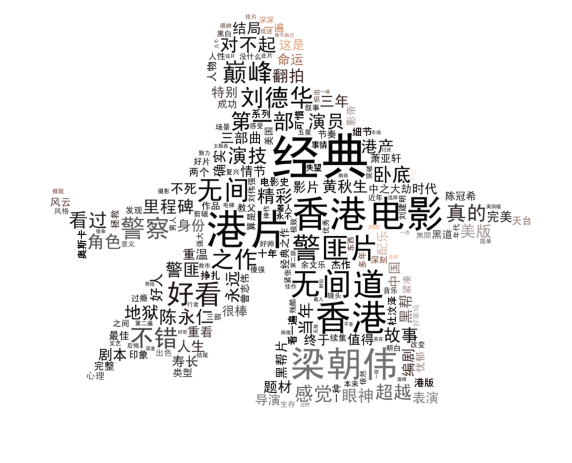

In [58]:
# 加入自定义图
# from scipy.misc import 
import imageio
matplotlib.rcParams['figure.figsize']=(10.0,10.0)
from wordcloud import WordCloud,ImageColorGenerator
bimg=imageio.imread('cover.jpg')
wordcloud=WordCloud(background_color="white",mask=bimg,font_path='../simhei.ttf',max_font_size=100)
word_frequence={x[0]:x[1] for x in words_stat.head(1000).values}
print('word_frequence', word_frequence)
wordcloud=wordcloud.fit_words(word_frequence)
bimgColors=ImageColorGenerator(bimg)
plt.axis("off")
plt.imshow(wordcloud.recolor(color_func=bimgColors))

In [59]:
# 用朴素贝叶斯完成中文文本分类器

In [60]:
data_com_X.label.value_counts()
print(data_com_X)

       movie_id  star                                            content  \
380     1307914     5                                  牛就牛在，他让所有演员都达到了巅峰   
381     1307914     4    我还是不能理解为什么美国人可以这么无耻直接拿本子过去拍出烂片还得了奥斯卡但是不给这部片子正名?   
382     1307914     5                                     当年我深刻的爱上了梁朝伟同学   
383     1307914     4                           看了美版的，才知道港版有多好看~55555555   
384     1307914     5  “出来混，迟早要还的。” 别说，这种港片老爸老妈们已经欣赏不了了，就连弟弟一起看都没坚持看完...   
...         ...   ...                                                ...   
20775   1307914     5                                                 1好   
20776   1307914     5                                    一定要看香港版, 結局很不一樣   
20777   1307914     5                              一切的一切，从少年时代的那一盒辣鱼蛋...   
20778   1307914     4  即使冲着全盛时期的香港全明星卡司，也是值得看的。陈老师阿乐（¯﹃¯）。。。（以下省略花痴一万...   
20779   1307914     5                                      深深的触动。准备还看一遍。   

       comment_id         people  useful_num                time  label  
380      1126

In [61]:
# 词云
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy
import codecs
import pandas as pd

def preprocess_text(content_lines,sentences,category):
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append((" ".join(segs), category))
        except:
            print(line)
            continue

In [62]:
data_com_X_1 = data_com_X[data_com_X.label == 1]
# print(data_com_X[data_com_X.label == 1])
data_com_X_0 = data_com_X[data_com_X.label == 0]
print(len(data_com_X[data_com_X.label == 0]))

43


In [63]:
# 下采样
sentences=[]
# print(data_com_X_1.content.dropna().values.tolist())
preprocess_text(data_com_X_1.content.dropna().values.tolist() ,sentences ,'like')
n=0
while n <20:
    preprocess_text(data_com_X_0.content.dropna().values.tolist() ,sentences ,'nlike')
    n +=1

In [64]:
import random
random.shuffle(sentences)
print(sentences)
for sentence in sentences[:2]:
    print(sentence[0], sentence[1])

[('文艺 商业 之间 成功 之作', 'like'), ('港片 越来越 没法 对于 这样 一部 做作 电影 只能 低头 叹息', 'nlike'), ('黑白两道', 'like'), ('貌似 睡着', 'nlike'), ('港片 经典', 'like'), ('无间 地狱 永无', 'like'), ('香港电影 高峰 时期', 'like'), ('一样 黑帮 2000 最好 港片', 'like'), ('四大 影帝 演技 本片 达到 登峰造极 堪称 炉火纯青 很多 心理 活动 通过 他们 眼神 准确 表达 淋漓尽致 尤其 梁朝伟 眼神 很多 因此 喜欢 梁朝伟 因此 卓越 表现 再次 获得 香港电影 金像奖 最佳 男主角 本片 荣获 22 香港电影 金像奖 最佳 电影 称得起 港片 经典 警匪片 经典', 'like'), ('超爱 香港电影', 'nlike'), ('小冬 一起 第二遍 以后 赞同 观点 这是 最好 黑道 警匪片', 'like'), ('貌似 睡着', 'nlike'), ('香港电影 最为 灿烂 一次 回光返照', 'nlike'), ('几年 这片 剪辑 配乐 摄影 人物 剧情 实在 无趣', 'nlike'), ('正面交锋 终于 看出 刘德华 面对 梁朝伟 真的 较劲 不甘 但是 无力', 'nlike'), ('只爱 第一部', 'nlike'), ('刘伟强 感觉 一向 很淡 觉得 个人风格 不够 强烈 至于 演技 可能 本身 不怎么 出来', 'like'), ('其实 这部 片子 没有 任何 好来 所有人 深沉 因此 无论怎样 可以 继续 展开 总结 一下 就是 一部 大家 从头到尾 努力 装着 一直 最后 还要 下去 片子 交换 角色 身份 片子 梁朝伟 过得 很杯 其实 所有人 着装 自己 身份 快要 忽悠 这个 原著', 'like'), ('至今 认为 好看 香港电影', 'nlike'), ('刘德华 最后 变好 最后 医生 陈慧琳 发现 梁朝伟 身份证明 一点 铺垫 没有', 'like'), ('没错 很酷', 'like'), ('按照 250 单子 补标 重看 眉尖 忧愁 煎熬 抉择 辗转 失眠 决战 天台 电梯 一曲 沙哑 响起 跟随 命运 逐流 每个 角色 出色 几乎 像是 一场 本色 演出

In [65]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score
#from sklearn.model_selection import train_test_split
# print(sentences)
x,y=zip(*sentences) #解压
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(
    analyzer='word', # tokenise by character ngrams 
    ngram_range=(1,4), # use ngrams of size 1 and 2 
    max_features=20000, # keep the most common 1000 ngrams
)
vec.fit(x)
def stratifiedkfold_cv(x,y,clf_class,shuffle=True,n_splits=5,**kwargs):
    stratifiedk_fold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle)
    y_pred = y[:]
    for train_index, test_index in stratifiedk_fold.split(x,y):
        X_train, X_test = x[train_index], x[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

NB = MultinomialNB
print(precision_score(y, stratifiedkfold_cv(vec.transform(x),np.array(y),NB), average='macro'))

0.8751246465902558


In [66]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

class TextClassifier():
    def __init__(self, classifier=MultinomialNB()):
        self.classifier = classifier
        self.vectorizer = CountVectorizer(analyzer='word'
                                          ,ngram_range=(1,4)
                                          ,max_features=20000)
    def features(self, X):
        return self.vectorizer.transform(X)
    
    def fit(self, X, y):
        self.vectorizer.fit(X)
        self.classifier.fit(self.features(X), y)
        
    def predict(self, x):
        return self.classifier.predict(self.features([x]))
    
    def score(self, X, y):
        return self.classifier.score(self.features(X), y)

In [67]:
# 后期模型优化
text_classifier=TextClassifier()
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1234)
text_classifier.fit(x_train,y_train)
print(text_classifier.predict('难得看到这么惨烈的公安警匪大战。'))
print(text_classifier.predict('不喜欢'))
print(text_classifier.predict('好想甩出一麻袋星'))
print(text_classifier.score(x_test,y_test))

['like']
['like']
['like']
0.9311827956989247


3.主题分析

In [68]:
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
 
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

In [69]:
# 构建词典
data_set = []
for content in content_X:
    segment = []
#     segs = jieba.analyse.extract_tags(content, topK=20, withWeight=False)
    segs = jieba.lcut(content)
    stopwords = pd.read_csv("../stopwords.txt" 
                              ,index_col=False
                              ,quoting=3
                              ,sep="\t"
                              ,names=['stopword']
                              ,encoding='utf-8') # quoting=3 全不引用 
    for seg in segs:
        if len(seg)>1 and seg!='\r\n' and seg not in stopwords.stopword.values.tolist():
            segment.append(seg)
    data_set.append(segment)
print(data_set)
dictionary = corpora.Dictionary(data_set)  # 构建词典
# print(dictionary.token2id)
corpus = [dictionary.doc2bow(text) for text in data_set]
# print(corpus)

[['演员', '巅峰'], ['理解', '美国', '无耻', '本子', '烂片', '奥斯卡', '正名'], ['当年', '深刻', '梁朝伟', '同学'], ['美版', '港版', '好看', '55555555'], ['港片', '老爸', '老妈', '欣赏', '弟弟', '成不了', '经典', '叹息'], ['百年不遇', '经典'], ['不好', '懂装'], ['无间道', '当年', '港片', '热气腾腾', '生命力', '不知', '人变', '人倦', '无间道', '后续', '声势', '闹猛', '打破', '港片', '沉沦', '僵局', '一具', '艳尸', '妆扮', '精美', '绝色', '终究', '死物', '网上', '这段', '评论', '深得我心'], ['爆头', '刘德华', '梁朝伟', '眼神', '震惊', '电梯', '电梯门', '来回', '开关', '震惊', '恢复', '残酷', '好人', '为民除害', '有人', '惦记着', '视为', '英雄', '社会', '恶人', '当道'], ['港片', '里程碑'], ['梁朝伟', '无与伦比', '忧郁', '眼神'], ['刘德华', '演戏'], ['经典', '港片', '无间道', '人生'], [], ['高中', '片尾', '发现', '陈永仁', '生日'], ['色调'], ['全世界', '香港电影', '刮目相看', '哲学', '角度', '探索', '人性', '感受', '身不由己', '之下', '那种', '窒息', '感受', '贪婪', '自私', '编剧', '确实', '出色', '梁朝伟', '松仁', '神化', '角色', '可圈可点', '一出', '多余', '地方', '多年', '美版', '忘旧', '这是', '港片', '里程碑'], ['梁朝伟', '演得', '真好', '配乐', '熟悉', '这是', '外国', '评分', '肯定', '更高', '办法', '豆瓣', '崇洋媚外'], ['后悔', '所有人', '演技', '太棒了', '萧亚轩'], ['好来', '所有人', '深沉', '无论怎样', '展开', '从头到尾',

In [70]:
# # Build the bigram and trigram models
# bigram = gensim.models.Phrases(data_set, min_count=5, threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data_set], threshold=100)  

# # Faster way to get a sentence clubbed as a trigram/bigram
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

# def make_bigrams(texts):
#     return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

# data_words_bigrams = make_bigrams(data_set)
# print(data_words_bigrams[:])

In [71]:
# 构建LDA模型
import pprint
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
num_topics = 9
# ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30,random_state = 1)   #分为5个主题,text:文本，已经表示成词袋了。num_topics: 提取的主题数id2word:词典passes:类似于在机器学习中常见的epoch，也就是训练了多少轮;random_state -这是一个种子（如果您想精确地重复训练过程）。
# pprint.pprint(ldamodel.print_topics(num_topics=num_topics, num_words=15))  #每个主题输出5个单词


mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=dictionary)
# pprint(ldamallet.print_topics(num_topics=20 , num_words=10))
pprint.pprint(ldamallet.show_topics(formatted=False))
# vector = ldamallet[corpus[0]] 
# print(vector)
# print(ldamallet.get_topics())
# pprint.pprint(ldamallet.print_topics(num_topics=20, num_words=10) )
# Compute Coherence Score
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_set, dictionary=dictionary, coherence='c_v')
# coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 44
total tokens: 4929
<10> LL/token: -9.60348
<20> LL/token: -9.45368
<30> LL/token: -9.39492
<40> LL/token: -9.36195

0	6.25	无间道 不错 真的 卧底 感觉 精彩 香港电影 美版 结局 黑帮片 完美 时代 余文乐 之间 细节 多年 深刻 改变 成功 依然 
1	6.25	无间 陈永仁 警匪 永远 剧本 身份 人生 不死 值得 一遍 经典之作 电影史 杰作 经典 陈冠希 寿长 紧凑 续集 刘建明 警察 
2	6.25	演技 港片 故事 港产 黑帮 超越 三年 重温 重看 配乐 之作 人物 萧亚轩 杜汶泽 挣扎 梁朝伟 好片 無間 黑白 一段 
3	6.25	香港 警察 里程碑 无间道 眼神 香港电影 特别 命运 不错 完整 忧郁 可惜 刘伟强 风格 东西 叙事 经典 佳作 结尾 此片 
4	6.25	巅峰 第一部 之作 看过 对不起 地狱 题材 确实 中国 终于 中之大劫 很棒 导演 这是 黑道 影片 系列 类型 经典 教父 
5	6.25	经典 角色 翻拍 无间道 黄秋生 好人 港片 表演 梁朝伟 警匪片 印象 天台 港版 一种 作品 十年 本来 明白 残酷 突破 
6	6.25	梁朝伟 警匪片 港片 刘德华 演员 编剧 情节 风云 影帝 看一遍 心理 美国 极致 人性 拍出 到位 一点 也许 这片 傻强 
7	6.25	经典 香港电影 好看 港片 当年 三部曲 曾志伟 奥斯卡 拯救 算是 生存 失望 很帅 讨厌 年代 后悔 2000 背后 市场 不想 

<50> LL/token: -9.30389
<60> LL/token: -9.32429
<70> LL/token: -9.31405
<80> LL/token: -9.28648
<90> LL/token: -9.27523


[(0,
  [('无间道', 0.09190031152647975),
   ('警察', 0.048286604361370715),
   ('感觉', 0.03426791277258567),
   ('第一部', 0.03271028037383177),
   ('里程碑', 0.028037383177570093),
   ('黑帮', 0.020249221183800622),
   ('当年', 0.01557632398753894),
   ('特别', 0.01557632398753894),
   ('重看', 0.014018691588785047),
   ('黑道', 0.012461059190031152)]),
 (1,
  [('无间', 0.06907894736842106),
   ('卧底', 0.03618421052631579),
   ('陈永仁', 0.03289473684210526),
   ('地狱', 0.029605263157894735),
   ('永远', 0.02631578947368421),
   ('翻拍', 0.02631578947368421),
   ('人生', 0.018092105263157895),
   ('终于', 0.01644736842105263),
   ('不死', 0.01644736842105263),
   ('看过', 0.01644736842105263)]),
 (2,
  [('港片', 0.1768595041322314),
   ('之作', 0.05454545454545454),
   ('对不起', 0.02809917355371901),
   ('港产', 0.026446280991735537),
   ('编剧', 0.019834710743801654),
   ('经典', 0.01487603305785124),
   ('时代', 0.01487603305785124),
   ('黑帮片', 0.013223140495867768),
   ('电影史', 0.011570247933884297),
   ('印象', 0.011570247933884297)]),
 

NameError: name 'coherence_ldamallet' is not defined

In [ ]:
#计算困惑度
def perplexity(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=15))
    print(ldamodel.log_perplexity(corpus))
    return ldamodel.log_perplexity(corpus)
#计算coherence
def coherence(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30,random_state = 1)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=10))
    ldacm = CoherenceModel(model=ldamodel, texts=data_set, dictionary=dictionary, coherence='c_v')
#     print(ldacm.get_coherence())
    return ldacm.get_coherence()

In [ ]:
# 绘制主题-coherence曲线，选择最佳主题数
x = range(1,15)
y = [perplexity(i) for i in x]  #如果想用困惑度就选这个
# y = [coherence(i) for i in x]
plt.plot(x, y)
plt.xlabel('主题数目')
plt.ylabel('coherence大小')
plt.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
plt.title('主题-coherence变化情况')
plt.show()

In [ ]:
#  通过上述主题评估，我们发现可以选择3作为主题个数，接下来我们可以再跑一次模型，设定主题数为5，并输出每个文档最有可能对应的主题
from gensim.models import LdaModel
import pandas as pd
from gensim.corpora import Dictionary
from gensim import corpora, models

 
dictionary = corpora.Dictionary(data_set)  # 构建词典
corpus = [dictionary.doc2bow(text) for text in data_set]
 
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=9, passes = 30,random_state=1)
topic_list=lda.print_topics()
pprint.pprint(topic_list)
for i in lda.get_document_topics(corpus)[:]:
    print('i==',i)
    listj=[]
    for j in i:
        print('j==', j)
        listj.append(j[1])
#     print(listj)
    bz=listj.index(max(listj))
#     print(i[bz][0])

# for topic in lda.print_topics(num_words = 20):
#     termNumber = topic[0]
#     print(topic[0], ':', sep='')
#     listOfTerms = topic[1].split('+')
#     for term in listOfTerms:
#         listItems = term.split('*')
#         print('  ', listItems[1], '(', listItems[0], ')', sep='')

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models
# 用pyLDAvis将LDA模式可视化
plot =pyLDAvis.gensim_models.prepare(lda,corpus,dictionary)
# pyLDAvis.show(plot)
# 保存到本地html
pyLDAvis.save_html(plot, 'pyLDAvis.html')
